In [7]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from genpen.utils import Paper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
def rule30(left, center, right):
    return left != (center | right)

def run_automata(vector, n_iterations, padtype='constant'):
    vectors = []
    for iteration in range(n_iterations):
        vectors.append(vector)
        if padtype == 'constant':
            padfunc = functools.partial(np.pad, pad_width=1, mode='constant', constant_values=0)
        elif padtype == 'wrap':
            padfunc = functools.partial(np.pad, pad_width=1, mode='wrap')
        padded = padfunc(vector).astype(bool)
            
        new_vector = np.zeros_like(vector)

        for ii in range(1, len(padded)-1):
            left = padded[ii-1]
            center = padded[ii]
            right = padded[ii+1]
            new_val = rule30(left, center, right)
            new_vector[ii-1] = new_val
        vector = new_vector
    return (1-np.stack(vectors).astype('uint8')) * 255

In [228]:
scale = 0.35

In [229]:
print((11 * scale, 17 * scale))

(3.8499999999999996, 5.949999999999999)


In [280]:
n_cols = 15
n_iterations = 3

init_vector = np.zeros(n_cols)
init_vector[np.floor(n_cols/2).astype(int)] = 1

In [283]:
np.nonzero(255-output)

(array([0, 1, 1, 1, 2, 2, 2]), array([7, 6, 7, 8, 5, 6, 9]))

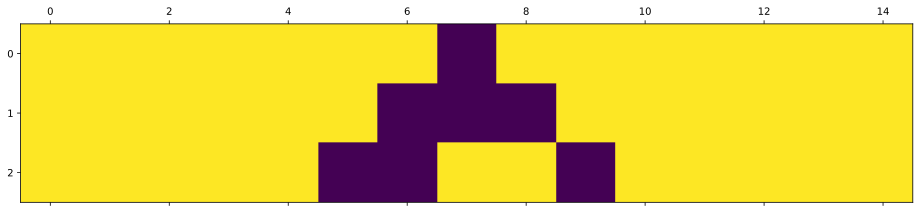

In [282]:
output = run_automata(init_vector, n_iterations, padtype='constant')
plt.matshow(output)

In [253]:
io.imsave('/mnt/c/code/side/plotter_images/bounded_rule30.jpeg', output, quality=100)

In [269]:
n_cols = 38
n_iterations = 64

init_vector = np.zeros(n_cols)
# init_vector[20] = 1
init_vector[35] = 1

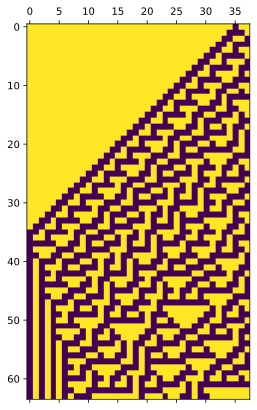

In [270]:
output = run_automata(init_vector, n_iterations, padtype='constant')
plt.matshow(output)

In [271]:
io.imsave('/mnt/c/code/side/plotter_images/bounded_rule30_2.jpeg', output, quality=100)

In [193]:
from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk
from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure

In [194]:

def local_angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

In [208]:
image_path = '/mnt/c/code/side/plotter_images/bounded_rule30.jpeg'
image_rescale_factor = 1
hist_clip_limit = 0.1
hist_nbins = 32
hatch_spacing_min = 0.3
hatch_spacing_max = 1
farid_disk_size = 0

<ipython-input-209-1611fe2ba9f4>:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img =  rgb2gray(io.imread(Path(image_path)))


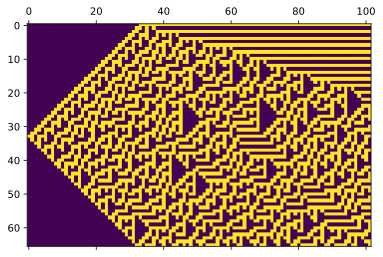

In [209]:
img =  rgb2gray(io.imread(Path(image_path)))
img_rescale = rescale(img, image_rescale_factor)
# 
img_contrast_adj = exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip_limit, nbins=hist_nbins)
img_renorm = img_contrast_adj * (hatch_spacing_max - 0.01 - hatch_spacing_min) + hatch_spacing_min

# calc dominant angle
selem = disk(farid_disk_size)
filt_img = filters.rank.mean(img_renorm, selem)
angle_farid = local_angle(filters.farid_h(filt_img), filters.farid_v(filt_img))
plt.matshow(filt_img.T)